In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from PIL import Image
import json
import os
import torchvision
import torchvision.transforms as transforms
from math import ceil, floor
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchinfo import summary

# Config

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 16
epochs = 50
lr = 0.001
split_size = 0.8

path_to_anns = "D:\\Studies\\ucenje\\keypoint_flickr\\data\\annotations\\all_data.json"
path_to_img = "D:\\Studies\\ucenje\\keypoint_flickr\\data\\images"

# Datasets and Dataloaders

## Regression

In [3]:
class FlickrDatasetRegression(Dataset):
    def __init__(self, path_to_anns, path_to_imgs):
        with open(path_to_anns, 'r') as f:
            self.anns = json.loads(f.read())
        self.image_path = path_to_imgs
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(224),
            torchvision.transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        """image = Image.open(path_to_img + "\\" + self.anns[str(idx)]["file_name"])
        keypoints = self.anns[str(idx)]["face_landmarks"]
        image = self.transform(image)
        return image, torch.tensor(keypoints).flatten() * 224/512, idx
        """
        img_path = os.path.join(self.image_path, self.anns[str(idx)]["file_name"])
        image = Image.open(img_path).convert("RGB")
        keypoints = np.array(self.anns[str(idx)]["face_landmarks"])
        image = self.transform(image)
        keypoints = torch.tensor(keypoints).flatten() * 224/512
        return image, torch.tensor(keypoints), idx

In [4]:
dataset = FlickrDatasetRegression(path_to_anns,path_to_img)
train_len = ceil(len(dataset) * split_size)
val_len = len(dataset) - train_len

train_dataset, val_dataset = torch.utils.data.random_split(dataset, (train_len, val_len))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

## Classification

In [5]:
class FlickrDatasetClassification(Dataset):
    def __init__(self, path_to_anns, path_to_imgs, transform=None):
        with open(path_to_anns, 'r') as f:
            self.anns = json.loads(f.read())
        self.image_path = path_to_imgs
        self.transform = transform

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_path, self.anns[str(idx)]["file_name"])
        image = Image.open(img_path).convert("RGB")
        orig_width, orig_height = image.size

        image.thumbnail((224, 224))
        image = np.array(image, dtype=np.uint8)
        keypoints = np.array(self.anns[str(idx)]["face_landmarks"], dtype=np.float32)
        keypoints = keypoints.clip(min=0, max=orig_height if orig_height >= orig_width else orig_width)
        keypoints = keypoints * [224.0 / orig_width, 224.0 / orig_height]
        keypoints = keypoints.astype('uint8')
        new_keypoints = torch.zeros(68, 224, 224)
        for i in range(len(new_keypoints)):
            new_keypoints[i][keypoints[i][0]-1][keypoints[i][1]-1] = 1
        if self.transform:
            image = self.transform(image)

        return image, new_keypoints, idx

dataset_classification = FlickrDatasetClassification(path_to_anns,path_to_img,
                        transform=transforms.ToTensor())
train_len = ceil(len(dataset_classification) * split_size)
val_len = ceil(len(dataset_classification) * (1-split_size))
train_dataset_classification, val_dataset_classification = torch.utils.data.random_split(dataset_classification, (train_len, val_len))
train_loader_classification = DataLoader(train_dataset_classification, batch_size=batch_size, shuffle=True)
val_loader_classification = DataLoader(val_dataset_classification, batch_size=1, shuffle=False)

# Utils

In [6]:
def get_top_images_dataloader(losses, dataset):
    sorted_loss = sorted(losses, key = lambda x: x[1])
    dataset_to_plot = sorted_loss[:10] + sorted_loss[-10:]
    indexes_to_plot = [x[0].item() for x in dataset_to_plot]
    new_data = [dataset[index] for index in indexes_to_plot]
    dataloader_for_plots = DataLoader(new_data, batch_size=1, shuffle=False)
    return dataloader_for_plots

In [7]:
def plot_img(predictions): # predictions list of tuple (index, predicted_keypoints)
    transform = transforms.ToPILImage() # transform tensor back to PILImage

    images, original_keypoints_list, predicted_keypoints_list = [], [], []

    for i, data in enumerate(predictions):
        image = dataset[data[0].item()][0]
        image = transform(image.cpu().detach())  # Images to PIL, keypoints to numpy array
        images.append(image)
        original_keypoints = dataset[data[0].item()][1]
        original_keypoints = original_keypoints.cpu().detach().numpy().reshape(-1, 2)
        original_keypoints_list.append(original_keypoints)
        predicted_keypoints = data[1].cpu().detach().numpy().reshape(-1, 2)
        predicted_keypoints_list.append(predicted_keypoints)
    original_keypoints_list = np.array(original_keypoints_list)
    predicted_keypoints_list = np.array(predicted_keypoints_list)


    plt.figure(figsize=(20,50), layout="constrained")

    for i in range(len(images) * 2):
        plt.subplot(20, 2, i + 1)
        plt.imshow(images[i // 2])
        if i % 2 == 0:
            for p in range(original_keypoints_list[i//2].shape[0]):
                plt.scatter(original_keypoints_list[i//2][p, 0], original_keypoints_list[i//2][p, 1], c="b")
        else:
            for p in range(predicted_keypoints_list[i//2].shape[0]):
                plt.scatter(predicted_keypoints_list[i//2][p, 0], predicted_keypoints_list[i//2][p, 1], c="r")
    plt.plot()

# Model Creation

## Regression Model

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(3)
        self.norm = nn.BatchNorm2d(32)
        self.linear1 = nn.Linear(32 * 74 * 74, 256) # 111
        self.linear2 = nn.Linear(256, 136)
    def forward(self, x):
        x = self.norm(self.pool(F.relu(self.conv(x))))
        x = x.view(-1, 32 * 74 * 74)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x



# Training loop for regression

In [9]:
def train_model_regression(epochs, weight_decay=0):

    torch.cuda.empty_cache()
    model = SimpleCNN().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        train_running_loss = 0.0
        for data in train_loader:
            images, keypoints = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)
            preds = model(images)
            loss = criterion(preds, keypoints)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_running_loss += loss.item()
        train_loss.append(train_running_loss / (ceil(len(train_dataset) / batch_size)))

        model.eval()

        with torch.no_grad():
            val_running_loss = 0.0
            for data in val_loader:
                image, keypoints = data[0].to(device), data[1].to(device)
                preds = model(image)
                loss = criterion(preds, keypoints)
                val_running_loss += loss.item()
            val_loss.append(val_running_loss / ceil(len(val_dataset) / 1))
        if epoch + 1 % 5 == 0:
            print(f'Epoch: {epoch + 1}')
            print(f'Train_loss at epoch {epoch + 1}: {train_loss[-1]}')
            print(f'Val_loss at epoch {epoch + 1}: {val_loss[-1]}')
    return model, criterion, train_loss, val_loss


In [10]:
model, criterion, total_train_loss, total_val_loss = None, None, [], []

train_runs = 5
for i in range(train_runs):
    if i == train_runs - 1:
        model,criterion, train_loss, val_loss = train_model_regression(epochs=epochs, weight_decay=0)
        total_train_loss.append(train_loss)
        total_val_loss.append(val_loss)
    else :
        _, _, train_loss, val_loss = train_model_regression(epochs=epochs, weight_decay=0)
        total_train_loss.append(train_loss)
        total_val_loss.append(val_loss)
print("------------TRAINING FINISHED------------")

C:\Users\user\AppData\Local\Temp\ipykernel_34736\1410555617.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(keypoints), idx


------------TRAINING FINISHED------------


# Plot the 5 training runs

In [35]:
average_loss = np.sum(total_train_loss, axis=0) / train_runs
average_std = np.std(total_train_loss, axis=0) / train_runs

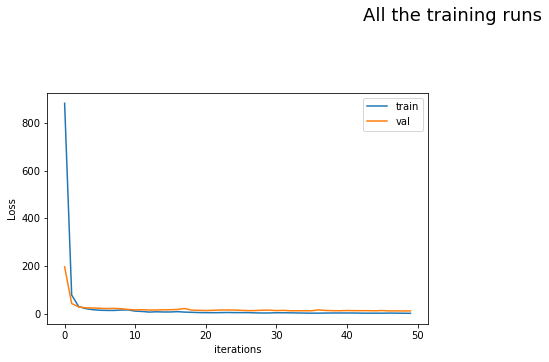

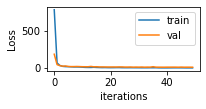

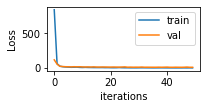

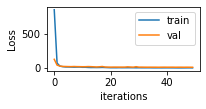

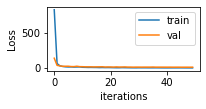

In [13]:
plt.figure(figsize=(15,17))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("All the training runs", fontsize=18, y=0.95)
for i in range(train_runs):
    ax = plt.subplot(3,2,i+1, adjustable="box")
    plt.plot(total_train_loss[i], label="train")
    plt.plot(total_val_loss[i], label="val")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [36]:
print(f"Average loss of all the training runs is {average_loss}")
print(f"Average loss in the last 10 epochs is {average_loss[-10]}")
print(f"Average std in all of the training runs is {average_std}")

Average loss of all the training runs is [834.56882961  68.82702469  29.70220331  20.5930167   16.44047584
  14.88470791  13.76054578  12.97838486  13.87254576  13.43544256
   9.97988759   9.44127473   7.6326483    7.68149148   7.71756439
   7.07738025   6.88007641   6.85718013   6.04422903   5.43783943
   4.65625126   4.40639369   4.44136484   5.13721999   4.59820211
   4.23596045   4.09425299   3.68303647   3.31220262   3.10636482
   3.57644214   3.41130348   3.28580211   3.07222534   2.95827278
   2.62246042   2.76512148   2.55538135   2.47583642   2.37970871
   2.35350756   2.36659517   2.30783999   2.19922152   2.16274938
   2.16766114   2.20838702   2.04063349   2.08534316   1.73908455]
Average loss in the last 10 epochs is 2.3535075594425203
Average std in all of the training runs is [6.76945453 1.127957   0.50441908 0.29375474 0.26296048 0.29869302
 0.36743207 0.14363942 0.2071994  0.45632842 0.22686778 0.16252723
 0.11658782 0.1173608  0.20598124 0.06568255 0.17676669 0.225769

## Validation for regression and getting top 10 best and worst predictions from last model pass

In [15]:
model.eval()

val_losses = []
with torch.no_grad():
    for i, data in tqdm(enumerate(val_loader), total=(len(val_loader))):
        image, keypoints, index = data[0].to(device), data[1].to(device), data[2]
        pred = model(image)
        loss = criterion(pred, keypoints)
        val_losses.append((index, loss.item(), pred))
    val_losses = sorted(val_losses, key = lambda x: x[1])
    val_losses = val_losses[:10] + val_losses[-10:] #(index, loss, pred)
    val_losses = [(x[0], x[2]) for x in val_losses]

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_34736\1410555617.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(keypoints), idx
100%|██████████| 1000/1000 [00:11<00:00, 88.54it/s]


C:\Users\user\AppData\Local\Temp\ipykernel_34736\1410555617.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(keypoints), idx


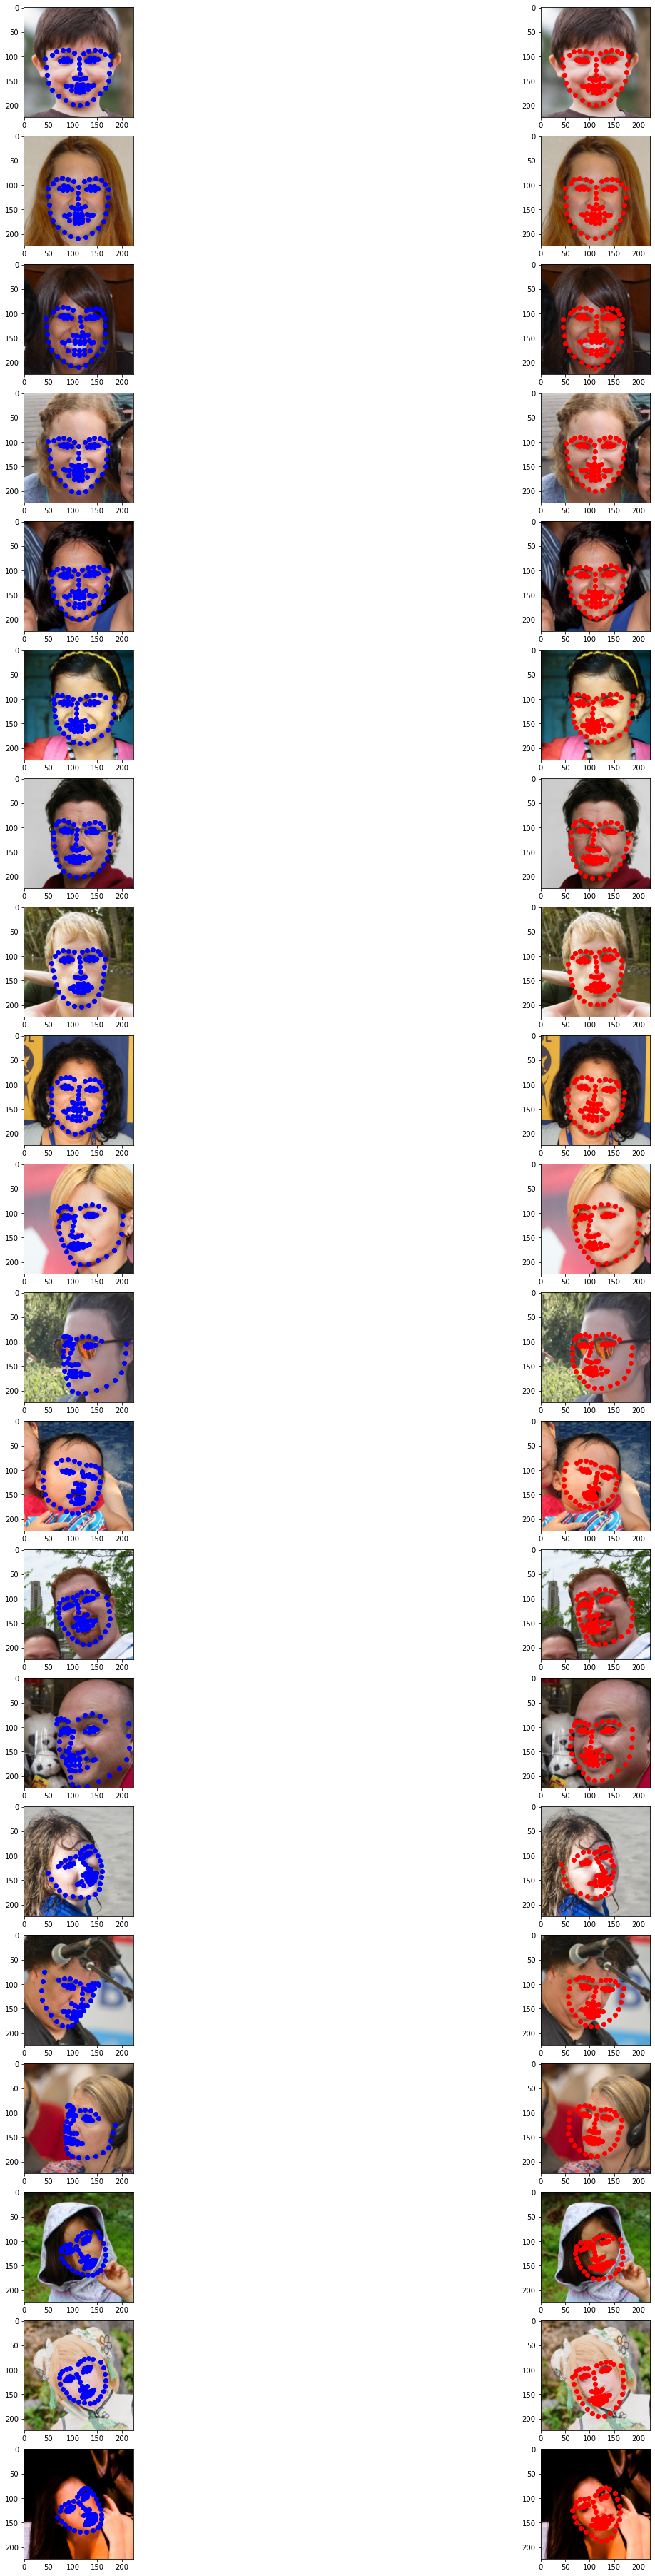

In [16]:
plot_img(val_losses)

# Transfer Learning tuka

In [17]:
# probaj vgg 19 mobilenet, resnet50, keypoint RCNN

In [18]:
vgg_model = torchvision.models.vgg19(pretrained=True)

C:\Users\user\anaconda3\envs\pytorch_tutorial\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\envs\pytorch_tutorial\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
for param in vgg_model.parameters():
    param.requires_grad = False
vgg_model.classifier.append(nn.Linear(1000, 136))

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
  (7): Linear(in_features=1000, out_features=136, bias=True)
)

In [20]:
torch.cuda.empty_cache()
model = vgg_model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss = []
val_loss = []
for epoch in range(epochs):
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), total=(len(train_loader))):
        images, keypoints = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)
        preds = model(images)
        loss = criterion(preds, keypoints)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_running_loss += loss.item()
    train_loss.append(train_running_loss / (ceil(len(train_dataset) / batch_size)))

    model.eval()

    with torch.no_grad():
        val_running_loss = 0.0
        for i, data in tqdm(enumerate(val_loader), total=(len(val_loader))):
            image, keypoints = data[0].to(device), data[1].to(device)
            preds = model(image)
            loss = criterion(preds, keypoints)
            val_running_loss += loss.item()
        val_loss.append(val_running_loss / ceil(len(val_dataset) / 1))
    print(f'Epoch: {epoch + 1}')
    print(f'Train_loss at epoch {epoch + 1}: {train_loss[-1]}')
    print(f'Val_loss at epoch {epoch + 1}: {val_loss[-1]}')


  0%|          | 0/250 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_34736\1410555617.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(keypoints), idx
100%|██████████| 1000/1000 [00:18<00:00, 53.52it/s]


Epoch: 1
Train_loss at epoch 1: 2678.0638248291016
Val_loss at epoch 1: 626.4792752796478


100%|██████████| 1000/1000 [00:18<00:00, 53.35it/s]


Epoch: 2
Train_loss at epoch 2: 412.40578399658204
Val_loss at epoch 2: 327.60031343985764


100%|██████████| 1000/1000 [00:18<00:00, 53.89it/s]


Epoch: 3
Train_loss at epoch 3: 294.86823916625974
Val_loss at epoch 3: 259.3506872015813


100%|██████████| 1000/1000 [00:18<00:00, 55.19it/s]


Epoch: 4
Train_loss at epoch 4: 247.73804571533202
Val_loss at epoch 4: 233.17177155066108


100%|██████████| 1000/1000 [00:18<00:00, 55.30it/s]


Epoch: 5
Train_loss at epoch 5: 224.27397073364259
Val_loss at epoch 5: 214.17781547703555


100%|██████████| 1000/1000 [00:18<00:00, 55.37it/s]


Epoch: 6
Train_loss at epoch 6: 208.89952424621583
Val_loss at epoch 6: 203.38092752491653


100%|██████████| 1000/1000 [00:18<00:00, 55.42it/s]


Epoch: 7
Train_loss at epoch 7: 197.78758297729493
Val_loss at epoch 7: 194.78685355179695


100%|██████████| 1000/1000 [00:18<00:00, 55.27it/s]


Epoch: 8
Train_loss at epoch 8: 189.09523999023438
Val_loss at epoch 8: 189.12004749753004


100%|██████████| 1000/1000 [00:18<00:00, 55.42it/s]


Epoch: 9
Train_loss at epoch 9: 183.0109421081543
Val_loss at epoch 9: 181.55479955132793


100%|██████████| 1000/1000 [00:18<00:00, 55.54it/s]


Epoch: 10
Train_loss at epoch 10: 176.96932305908203
Val_loss at epoch 10: 177.49460516480482


100%|██████████| 1000/1000 [00:18<00:00, 55.43it/s]


Epoch: 11
Train_loss at epoch 11: 172.19616104125976
Val_loss at epoch 11: 174.22580938248583


100%|██████████| 1000/1000 [00:18<00:00, 55.41it/s]


Epoch: 12
Train_loss at epoch 12: 168.18982986450195
Val_loss at epoch 12: 170.22728574689216


100%|██████████| 1000/1000 [00:17<00:00, 58.52it/s]


Epoch: 13
Train_loss at epoch 13: 164.78833309936525
Val_loss at epoch 13: 165.42933796619212


100%|██████████| 1000/1000 [00:18<00:00, 55.21it/s]


Epoch: 14
Train_loss at epoch 14: 162.06766619873048
Val_loss at epoch 14: 165.1748945256768


100%|██████████| 1000/1000 [00:18<00:00, 55.37it/s]


Epoch: 15
Train_loss at epoch 15: 159.29830737304687
Val_loss at epoch 15: 161.57297968371782


100%|██████████| 1000/1000 [00:17<00:00, 57.34it/s]


Epoch: 16
Train_loss at epoch 16: 156.52458395385742
Val_loss at epoch 16: 162.47060588836283


100%|██████████| 1000/1000 [00:18<00:00, 55.31it/s]


Epoch: 17
Train_loss at epoch 17: 154.24242417907715
Val_loss at epoch 17: 161.73400898860723


100%|██████████| 1000/1000 [00:18<00:00, 55.31it/s]


Epoch: 18
Train_loss at epoch 18: 152.65066647338867
Val_loss at epoch 18: 155.8761588304


100%|██████████| 1000/1000 [00:18<00:00, 55.39it/s]


Epoch: 19
Train_loss at epoch 19: 150.8383980407715
Val_loss at epoch 19: 153.2466100927785


100%|██████████| 1000/1000 [00:18<00:00, 55.20it/s]


Epoch: 20
Train_loss at epoch 20: 149.00884896850587
Val_loss at epoch 20: 152.79180830433754


100%|██████████| 1000/1000 [00:18<00:00, 55.27it/s]


Epoch: 21
Train_loss at epoch 21: 148.33363816833497
Val_loss at epoch 21: 150.35391785730198


100%|██████████| 1000/1000 [00:17<00:00, 57.30it/s]


Epoch: 22
Train_loss at epoch 22: 145.93846438598632
Val_loss at epoch 22: 153.28739044555243


100%|██████████| 1000/1000 [00:17<00:00, 56.37it/s]


Epoch: 23
Train_loss at epoch 23: 144.9399555206299
Val_loss at epoch 23: 147.9250527950702


100%|██████████| 1000/1000 [00:17<00:00, 57.91it/s]


Epoch: 24
Train_loss at epoch 24: 144.02415673828125
Val_loss at epoch 24: 147.2407286666839


100%|██████████| 1000/1000 [00:17<00:00, 58.31it/s]


Epoch: 25
Train_loss at epoch 25: 142.68962579345703
Val_loss at epoch 25: 146.26766245719836


100%|██████████| 1000/1000 [00:18<00:00, 55.28it/s]


Epoch: 26
Train_loss at epoch 26: 141.78837728881837
Val_loss at epoch 26: 145.8855035708303


100%|██████████| 1000/1000 [00:18<00:00, 52.86it/s]


Epoch: 27
Train_loss at epoch 27: 139.91853791809083
Val_loss at epoch 27: 148.85065394661285


100%|██████████| 1000/1000 [00:18<00:00, 55.40it/s]


Epoch: 28
Train_loss at epoch 28: 139.30082928466797
Val_loss at epoch 28: 143.13358809029938


100%|██████████| 1000/1000 [00:18<00:00, 54.96it/s]


Epoch: 29
Train_loss at epoch 29: 138.30501513671874
Val_loss at epoch 29: 143.0582952633863


100%|██████████| 1000/1000 [00:19<00:00, 51.63it/s]


Epoch: 30
Train_loss at epoch 30: 136.69032202148438
Val_loss at epoch 30: 141.39764163517003


100%|██████████| 1000/1000 [00:19<00:00, 50.67it/s]


Epoch: 31
Train_loss at epoch 31: 136.6054218597412
Val_loss at epoch 31: 140.77584334431026


100%|██████████| 1000/1000 [00:19<00:00, 50.64it/s]


Epoch: 32
Train_loss at epoch 32: 136.06047689819337
Val_loss at epoch 32: 140.69686597218077


100%|██████████| 1000/1000 [00:19<00:00, 50.87it/s]


Epoch: 33
Train_loss at epoch 33: 134.7809764099121
Val_loss at epoch 33: 139.83307684341509


100%|██████████| 1000/1000 [00:18<00:00, 53.19it/s]


Epoch: 34
Train_loss at epoch 34: 134.24227139282226
Val_loss at epoch 34: 139.02348222425348


100%|██████████| 1000/1000 [00:18<00:00, 54.33it/s]


Epoch: 35
Train_loss at epoch 35: 133.11301965332032
Val_loss at epoch 35: 137.0749212545515


100%|██████████| 1000/1000 [00:18<00:00, 53.87it/s]


Epoch: 36
Train_loss at epoch 36: 132.49514993286132
Val_loss at epoch 36: 140.22644440975947


100%|██████████| 1000/1000 [00:18<00:00, 53.40it/s]


Epoch: 37
Train_loss at epoch 37: 132.63550526428222
Val_loss at epoch 37: 139.0278004823527


100%|██████████| 1000/1000 [00:18<00:00, 53.55it/s]


Epoch: 38
Train_loss at epoch 38: 131.51408729553222
Val_loss at epoch 38: 136.76535232613975


100%|██████████| 1000/1000 [00:18<00:00, 53.57it/s]


Epoch: 39
Train_loss at epoch 39: 130.50639205932617
Val_loss at epoch 39: 143.1548990878435


100%|██████████| 1000/1000 [00:19<00:00, 51.73it/s]


Epoch: 40
Train_loss at epoch 40: 130.14065382385255
Val_loss at epoch 40: 138.60060318728404


100%|██████████| 1000/1000 [00:19<00:00, 51.76it/s]


Epoch: 41
Train_loss at epoch 41: 130.74294454956055
Val_loss at epoch 41: 139.96031685930623


100%|██████████| 1000/1000 [00:19<00:00, 52.44it/s]


Epoch: 42
Train_loss at epoch 42: 128.46499786376953
Val_loss at epoch 42: 134.2824521050107


100%|██████████| 1000/1000 [00:19<00:00, 52.59it/s]


Epoch: 43
Train_loss at epoch 43: 127.98818629455566
Val_loss at epoch 43: 135.03993918763936


100%|██████████| 1000/1000 [00:19<00:00, 51.51it/s]


Epoch: 44
Train_loss at epoch 44: 127.68454592895507
Val_loss at epoch 44: 134.59064909762168


100%|██████████| 1000/1000 [00:21<00:00, 46.02it/s]


Epoch: 45
Train_loss at epoch 45: 127.05438957214355
Val_loss at epoch 45: 136.81220569162596


100%|██████████| 1000/1000 [00:22<00:00, 45.17it/s]


Epoch: 46
Train_loss at epoch 46: 126.80202969360352
Val_loss at epoch 46: 133.4790788837505


100%|██████████| 1000/1000 [00:19<00:00, 50.82it/s]


Epoch: 47
Train_loss at epoch 47: 126.3025619354248
Val_loss at epoch 47: 134.2060436950606


100%|██████████| 1000/1000 [00:20<00:00, 48.50it/s]


Epoch: 48
Train_loss at epoch 48: 125.31679747009278
Val_loss at epoch 48: 133.06176379780564


100%|██████████| 1000/1000 [00:22<00:00, 44.84it/s]


Epoch: 49
Train_loss at epoch 49: 125.56125910949707
Val_loss at epoch 49: 132.50273274958744


100%|██████████| 1000/1000 [00:19<00:00, 51.89it/s]

Epoch: 50
Train_loss at epoch 50: 124.70305523681641
Val_loss at epoch 50: 131.2997232289483


In [21]:
resnet_model = torchvision.models.resnet50(weights="DEFAULT")

In [22]:

resnet_model.fc = nn.Linear(2048, 136)

In [23]:
torch.cuda.empty_cache()
model = resnet_model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss = []
val_loss = []
for epoch in range(epochs):
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), total=(len(train_loader))):
        images, keypoints = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)
        preds = model(images)
        loss = criterion(preds, keypoints)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_running_loss += loss.item()
    train_loss.append(train_running_loss / (ceil(len(train_dataset) / batch_size)))

    model.eval()

    with torch.no_grad():
        val_running_loss = 0.0
        for i, data in tqdm(enumerate(val_loader), total=(len(val_loader))):
            image, keypoints = data[0].to(device), data[1].to(device)
            preds = model(image)
            loss = criterion(preds, keypoints)
            val_running_loss += loss.item()
        val_loss.append(val_running_loss / ceil(len(val_dataset) / 1))
    print(f'Epoch: {epoch + 1}')
    print(f'Train_loss at epoch {epoch + 1}: {train_loss[-1]}')
    print(f'Val_loss at epoch {epoch + 1}: {val_loss[-1]}')


  0%|          | 0/250 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_34736\1410555617.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(keypoints), idx
100%|██████████| 1000/1000 [00:19<00:00, 51.98it/s]


Epoch: 1
Train_loss at epoch 1: 1167.1748011932373
Val_loss at epoch 1: 152.58568104163126


100%|██████████| 1000/1000 [00:19<00:00, 50.18it/s]


Epoch: 2
Train_loss at epoch 2: 589640.9828452759
Val_loss at epoch 2: 73.74009057241264


100%|██████████| 1000/1000 [00:17<00:00, 57.22it/s]


Epoch: 3
Train_loss at epoch 3: 65.60503698730469
Val_loss at epoch 3: 58.74421174834832


100%|██████████| 1000/1000 [00:18<00:00, 54.91it/s]


Epoch: 4
Train_loss at epoch 4: 63.050658447265626
Val_loss at epoch 4: 55.9976803083259


100%|██████████| 1000/1000 [00:17<00:00, 55.94it/s]


Epoch: 5
Train_loss at epoch 5: 62.43105149841308
Val_loss at epoch 5: 55.54857963228703


100%|██████████| 1000/1000 [00:17<00:00, 56.87it/s]


Epoch: 6
Train_loss at epoch 6: 63.08003438568115
Val_loss at epoch 6: 59.32430314298429


100%|██████████| 1000/1000 [00:17<00:00, 56.58it/s]


Epoch: 7
Train_loss at epoch 7: 62.77957276153565
Val_loss at epoch 7: 55.89748272893462


100%|██████████| 1000/1000 [00:17<00:00, 56.40it/s]


Epoch: 8
Train_loss at epoch 8: 62.955572280883786
Val_loss at epoch 8: 58.2737418291456


100%|██████████| 1000/1000 [00:18<00:00, 53.73it/s]


Epoch: 9
Train_loss at epoch 9: 63.54410674285889
Val_loss at epoch 9: 87.51970455414163


100%|██████████| 1000/1000 [00:18<00:00, 54.70it/s]


Epoch: 10
Train_loss at epoch 10: 61.837580337524415
Val_loss at epoch 10: 59.35514669423143


100%|██████████| 1000/1000 [00:17<00:00, 55.96it/s]


Epoch: 11
Train_loss at epoch 11: 62.521217697143555
Val_loss at epoch 11: 57.74138753668582


100%|██████████| 1000/1000 [00:17<00:00, 57.15it/s]


Epoch: 12
Train_loss at epoch 12: 66.60761324310303
Val_loss at epoch 12: 68.89877522355535


100%|██████████| 1000/1000 [00:18<00:00, 55.07it/s]


Epoch: 13
Train_loss at epoch 13: 61.066886108398435
Val_loss at epoch 13: 61.80434045038597


100%|██████████| 1000/1000 [00:17<00:00, 56.64it/s]


Epoch: 14
Train_loss at epoch 14: 59.58043409729004
Val_loss at epoch 14: 54.74601783508591


100%|██████████| 1000/1000 [00:18<00:00, 55.29it/s]


Epoch: 15
Train_loss at epoch 15: 62.59181744384766
Val_loss at epoch 15: 67.55120497057209


100%|██████████| 1000/1000 [00:18<00:00, 54.18it/s]


Epoch: 16
Train_loss at epoch 16: 64.64723261260987
Val_loss at epoch 16: 55.42791409545189


100%|██████████| 1000/1000 [00:18<00:00, 55.40it/s]


Epoch: 17
Train_loss at epoch 17: 59.15193370056152
Val_loss at epoch 17: 56.512492150426695


100%|██████████| 1000/1000 [00:18<00:00, 52.93it/s]


Epoch: 18
Train_loss at epoch 18: 64.21810640716552
Val_loss at epoch 18: 56.42628071445169


100%|██████████| 1000/1000 [00:17<00:00, 56.02it/s]


Epoch: 19
Train_loss at epoch 19: 62.461368309021
Val_loss at epoch 19: 70.31842135525906


100%|██████████| 1000/1000 [00:17<00:00, 58.78it/s]


Epoch: 20
Train_loss at epoch 20: 60.85398504638672
Val_loss at epoch 20: 74.31616361081981


100%|██████████| 1000/1000 [00:17<00:00, 58.12it/s]


Epoch: 21
Train_loss at epoch 21: 59.72528163146973
Val_loss at epoch 21: 55.39186821734995


100%|██████████| 1000/1000 [00:17<00:00, 57.18it/s]


Epoch: 22
Train_loss at epoch 22: 61.467018829345704
Val_loss at epoch 22: 56.22027591381452


100%|██████████| 1000/1000 [00:17<00:00, 57.88it/s]


Epoch: 23
Train_loss at epoch 23: 61.89235842895508
Val_loss at epoch 23: 54.613731108489084


100%|██████████| 1000/1000 [00:16<00:00, 58.92it/s]


Epoch: 24
Train_loss at epoch 24: 62.88465824890137
Val_loss at epoch 24: 63.96795586932451


100%|██████████| 1000/1000 [00:16<00:00, 59.01it/s]


Epoch: 25
Train_loss at epoch 25: 59.8852864074707
Val_loss at epoch 25: 55.17779940966753


100%|██████████| 1000/1000 [00:17<00:00, 58.54it/s]


Epoch: 26
Train_loss at epoch 26: 59.48023633575439
Val_loss at epoch 26: 67.6288087958757


100%|██████████| 1000/1000 [00:17<00:00, 58.15it/s]


Epoch: 27
Train_loss at epoch 27: 58.75265162658691
Val_loss at epoch 27: 55.772071234524056


100%|██████████| 1000/1000 [00:16<00:00, 59.03it/s]


Epoch: 28
Train_loss at epoch 28: 59.91777815246582
Val_loss at epoch 28: 58.80183346406556


100%|██████████| 1000/1000 [00:16<00:00, 59.12it/s]


Epoch: 29
Train_loss at epoch 29: 59.20945455932617
Val_loss at epoch 29: 65.90940105724263


100%|██████████| 1000/1000 [00:16<00:00, 59.12it/s]


Epoch: 30
Train_loss at epoch 30: 62.01590740966797
Val_loss at epoch 30: 64.48609527719596


100%|██████████| 1000/1000 [00:17<00:00, 57.45it/s]


Epoch: 31
Train_loss at epoch 31: 59.49893864440918
Val_loss at epoch 31: 54.62698580462535


100%|██████████| 1000/1000 [00:16<00:00, 58.91it/s]


Epoch: 32
Train_loss at epoch 32: 62.5953201751709
Val_loss at epoch 32: 53.966660565814955


100%|██████████| 1000/1000 [00:16<00:00, 59.55it/s]


Epoch: 33
Train_loss at epoch 33: 60.84980165100097
Val_loss at epoch 33: 58.76252619318402


100%|██████████| 1000/1000 [00:17<00:00, 58.79it/s]


Epoch: 34
Train_loss at epoch 34: 57.32626760864258
Val_loss at epoch 34: 53.90277636374975


100%|██████████| 1000/1000 [00:17<00:00, 58.75it/s]


Epoch: 35
Train_loss at epoch 35: 60.27705597686768
Val_loss at epoch 35: 68.60103407179139


100%|██████████| 1000/1000 [00:16<00:00, 58.99it/s]


Epoch: 36
Train_loss at epoch 36: 58.95199112701416
Val_loss at epoch 36: 57.43574382367379


100%|██████████| 1000/1000 [00:16<00:00, 59.17it/s]


Epoch: 37
Train_loss at epoch 37: 58.11485730743408
Val_loss at epoch 37: 54.94521521764218


100%|██████████| 1000/1000 [00:16<00:00, 59.13it/s]


Epoch: 38
Train_loss at epoch 38: 60.121392578125
Val_loss at epoch 38: 54.664395959367916


100%|██████████| 1000/1000 [00:17<00:00, 58.64it/s]


Epoch: 39
Train_loss at epoch 39: 61.280673538208006
Val_loss at epoch 39: 54.205291792475336


100%|██████████| 1000/1000 [00:16<00:00, 59.16it/s]


Epoch: 40
Train_loss at epoch 40: 59.47330947113037
Val_loss at epoch 40: 58.84842534997454


100%|██████████| 1000/1000 [00:16<00:00, 59.09it/s]


Epoch: 41
Train_loss at epoch 41: 61.90398043823242
Val_loss at epoch 41: 55.43189123954871


100%|██████████| 1000/1000 [00:17<00:00, 58.80it/s]


Epoch: 42
Train_loss at epoch 42: 58.20703987121582
Val_loss at epoch 42: 61.94821332229562


100%|██████████| 1000/1000 [00:17<00:00, 56.44it/s]


Epoch: 43
Train_loss at epoch 43: 58.31863904571533
Val_loss at epoch 43: 71.75812723953158


100%|██████████| 1000/1000 [00:16<00:00, 58.88it/s]


Epoch: 44
Train_loss at epoch 44: 57.92650747680664
Val_loss at epoch 44: 54.998617873687074


100%|██████████| 1000/1000 [00:16<00:00, 58.94it/s]


Epoch: 45
Train_loss at epoch 45: 59.21593186187744
Val_loss at epoch 45: 56.36743837621714


100%|██████████| 1000/1000 [00:16<00:00, 59.55it/s]


Epoch: 46
Train_loss at epoch 46: 59.176585762023926
Val_loss at epoch 46: 53.41554881893183


100%|██████████| 1000/1000 [00:17<00:00, 58.78it/s]


Epoch: 47
Train_loss at epoch 47: 58.494889556884765
Val_loss at epoch 47: 54.167559222962595


100%|██████████| 1000/1000 [00:16<00:00, 59.19it/s]


Epoch: 48
Train_loss at epoch 48: 58.591468505859375
Val_loss at epoch 48: 54.70288020958568


100%|██████████| 1000/1000 [00:16<00:00, 59.12it/s]


Epoch: 49
Train_loss at epoch 49: 58.241344802856446
Val_loss at epoch 49: 53.30608647384641


100%|██████████| 1000/1000 [00:16<00:00, 59.50it/s]

Epoch: 50
Train_loss at epoch 50: 56.32021842193603
Val_loss at epoch 50: 52.082975237483936


In [24]:
inception_model = torchvision.models.inception_v3(weights="DEFAULT")

In [25]:
for param in model.parameters():
    param.requires_grad = True
inception_model.fc = nn.Linear(inception_model.fc.in_features, 136)

In [26]:
torch.cuda.empty_cache()
model = inception_model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss = []
val_loss = []
for epoch in range(epochs):
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), total=(len(train_loader))):
        images, keypoints = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)
        preds = model(images)
        loss = criterion(preds, keypoints)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_running_loss += loss.item()
    train_loss.append(train_running_loss / (ceil(len(train_dataset) / batch_size)))

    model.eval()

    with torch.no_grad():
        val_running_loss = 0.0
        for i, data in tqdm(enumerate(val_loader), total=(len(val_loader))):
            image, keypoints = data[0].to(device), data[1].to(device)
            preds = model(image)
            loss = criterion(preds, keypoints)
            val_running_loss += loss.item()
        val_loss.append(val_running_loss / ceil(len(val_dataset) / 1))
    print(f'Epoch: {epoch + 1}')
    print(f'Train_loss at epoch {epoch + 1}: {train_loss[-1]}')
    print(f'Val_loss at epoch {epoch + 1}: {val_loss[-1]}')


  0%|          | 0/250 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_34736\1410555617.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(keypoints), idx
  0%|          | 0/250 [00:00<?, ?it/s]


RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

In [27]:
mobilenet_model = torchvision.models.mobilenet_v2(weights="DEFAULT")

In [32]:
for param in mobilenet_model.parameters():
    param.requires_grad = False
mobilenet_model.classifier[1] = nn.Linear(1280, 136)

In [33]:
torch.cuda.empty_cache()
model = mobilenet_model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss = []
val_loss = []
for epoch in range(epochs):
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), total=(len(train_loader))):
        images, keypoints = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)
        preds = model(images)
        loss = criterion(preds, keypoints)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_running_loss += loss.item()
    train_loss.append(train_running_loss / (ceil(len(train_dataset) / batch_size)))

    model.eval()

    with torch.no_grad():
        val_running_loss = 0.0
        for i, data in tqdm(enumerate(val_loader), total=(len(val_loader))):
            image, keypoints = data[0].to(device), data[1].to(device)
            preds = model(image)
            loss = criterion(preds, keypoints)
            val_running_loss += loss.item()
        val_loss.append(val_running_loss / ceil(len(val_dataset) / 1))
    print(f'Epoch: {epoch + 1}')
    print(f'Train_loss at epoch {epoch + 1}: {train_loss[-1]}')
    print(f'Val_loss at epoch {epoch + 1}: {val_loss[-1]}')


  0%|          | 0/250 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_34736\1410555617.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(keypoints), idx
100%|██████████| 1000/1000 [00:15<00:00, 65.73it/s]


Epoch: 1
Train_loss at epoch 1: 16662.73952734375
Val_loss at epoch 1: 16650.594144060393


100%|██████████| 1000/1000 [00:14<00:00, 68.56it/s]


Epoch: 2
Train_loss at epoch 2: 16600.5398203125
Val_loss at epoch 2: 16588.45229212428


100%|██████████| 1000/1000 [00:14<00:00, 67.21it/s]


Epoch: 3
Train_loss at epoch 3: 16538.52896484375
Val_loss at epoch 3: 16526.489436663527


100%|██████████| 1000/1000 [00:14<00:00, 67.19it/s]


Epoch: 4
Train_loss at epoch 4: 16476.69103125
Val_loss at epoch 4: 16464.69539540057


100%|██████████| 1000/1000 [00:15<00:00, 64.23it/s]


Epoch: 5
Train_loss at epoch 5: 16415.023671875
Val_loss at epoch 5: 16403.068766210086


100%|██████████| 1000/1000 [00:14<00:00, 68.02it/s]


Epoch: 6
Train_loss at epoch 6: 16353.519140625
Val_loss at epoch 6: 16341.606380030096


100%|██████████| 1000/1000 [00:14<00:00, 68.92it/s]


Epoch: 7
Train_loss at epoch 7: 16292.17256640625
Val_loss at epoch 7: 16280.295364270587


100%|██████████| 1000/1000 [00:14<00:00, 68.41it/s]


Epoch: 8
Train_loss at epoch 8: 16230.980609375
Val_loss at epoch 8: 16219.138108984112


100%|██████████| 1000/1000 [00:14<00:00, 68.93it/s]


Epoch: 9
Train_loss at epoch 9: 16169.94308203125
Val_loss at epoch 9: 16158.133375178102


100%|██████████| 1000/1000 [00:14<00:00, 67.93it/s]


Epoch: 10
Train_loss at epoch 10: 16109.05319921875
Val_loss at epoch 10: 16097.278796827914


100%|██████████| 1000/1000 [00:14<00:00, 68.47it/s]


Epoch: 11
Train_loss at epoch 11: 16048.30617578125
Val_loss at epoch 11: 16036.557929253904


100%|██████████| 1000/1000 [00:14<00:00, 68.32it/s]


Epoch: 12
Train_loss at epoch 12: 15987.69941796875
Val_loss at epoch 12: 15975.983071694123


100%|██████████| 1000/1000 [00:14<00:00, 68.78it/s]


Epoch: 13
Train_loss at epoch 13: 15927.23315234375
Val_loss at epoch 13: 15915.543073039664


100%|██████████| 1000/1000 [00:14<00:00, 68.46it/s]


Epoch: 14
Train_loss at epoch 14: 15866.904203125
Val_loss at epoch 14: 15855.239610355915


100%|██████████| 1000/1000 [00:14<00:00, 68.88it/s]


Epoch: 15
Train_loss at epoch 15: 15806.7099140625
Val_loss at epoch 15: 15795.074414391609


100%|██████████| 1000/1000 [00:14<00:00, 67.97it/s]


Epoch: 16
Train_loss at epoch 16: 15746.64809375
Val_loss at epoch 16: 15735.032348543313


100%|██████████| 1000/1000 [00:14<00:00, 68.91it/s]


Epoch: 17
Train_loss at epoch 17: 15686.7177109375
Val_loss at epoch 17: 15675.128261105594


100%|██████████| 1000/1000 [00:14<00:00, 68.14it/s]


Epoch: 18
Train_loss at epoch 18: 15626.91884765625
Val_loss at epoch 18: 15615.355177317699


100%|██████████| 1000/1000 [00:14<00:00, 69.12it/s]


Epoch: 19
Train_loss at epoch 19: 15567.24875
Val_loss at epoch 19: 15555.711017493231


100%|██████████| 1000/1000 [00:15<00:00, 65.93it/s]


Epoch: 20
Train_loss at epoch 20: 15507.70731640625
Val_loss at epoch 20: 15496.189332487756


100%|██████████| 1000/1000 [00:14<00:00, 66.98it/s]


Epoch: 21
Train_loss at epoch 21: 15448.29385546875
Val_loss at epoch 21: 15436.797148792031


100%|██████████| 1000/1000 [00:15<00:00, 63.95it/s]


Epoch: 22
Train_loss at epoch 22: 15389.00777734375
Val_loss at epoch 22: 15377.533255796203


100%|██████████| 1000/1000 [00:14<00:00, 66.97it/s]


Epoch: 23
Train_loss at epoch 23: 15329.84823828125
Val_loss at epoch 23: 15318.397237543368


100%|██████████| 1000/1000 [00:15<00:00, 65.88it/s]


Epoch: 24
Train_loss at epoch 24: 15270.814296875
Val_loss at epoch 24: 15259.38300299112


100%|██████████| 1000/1000 [00:14<00:00, 66.88it/s]


Epoch: 25
Train_loss at epoch 25: 15211.90595703125
Val_loss at epoch 25: 15200.497975596221


100%|██████████| 1000/1000 [00:15<00:00, 66.51it/s]


Epoch: 26
Train_loss at epoch 26: 15153.12208203125
Val_loss at epoch 26: 15141.73405353643


100%|██████████| 1000/1000 [00:14<00:00, 67.23it/s]


Epoch: 27
Train_loss at epoch 27: 15094.46315234375
Val_loss at epoch 27: 15083.098563989428


100%|██████████| 1000/1000 [00:14<00:00, 67.37it/s]


Epoch: 28
Train_loss at epoch 28: 15035.92938671875
Val_loss at epoch 28: 15024.588262760808


100%|██████████| 1000/1000 [00:14<00:00, 67.83it/s]


Epoch: 29
Train_loss at epoch 29: 14977.5196953125
Val_loss at epoch 29: 14966.194847627492


100%|██████████| 1000/1000 [00:14<00:00, 67.75it/s]


Epoch: 30
Train_loss at epoch 30: 14919.23421484375
Val_loss at epoch 30: 14907.93214551648


100%|██████████| 1000/1000 [00:15<00:00, 66.10it/s]


Epoch: 31
Train_loss at epoch 31: 14861.0738046875
Val_loss at epoch 31: 14849.793993726531


100%|██████████| 1000/1000 [00:14<00:00, 67.87it/s]


Epoch: 32
Train_loss at epoch 32: 14803.03759375
Val_loss at epoch 32: 14791.782343427416


100%|██████████| 1000/1000 [00:15<00:00, 66.40it/s]


Epoch: 33
Train_loss at epoch 33: 14745.12505078125
Val_loss at epoch 33: 14733.88472281234


100%|██████████| 1000/1000 [00:14<00:00, 67.25it/s]


Epoch: 34
Train_loss at epoch 34: 14687.33612890625
Val_loss at epoch 34: 14676.121265550868


100%|██████████| 1000/1000 [00:14<00:00, 67.66it/s]


Epoch: 35
Train_loss at epoch 35: 14629.67301953125
Val_loss at epoch 35: 14618.475730797063


100%|██████████| 1000/1000 [00:14<00:00, 66.72it/s]


Epoch: 36
Train_loss at epoch 36: 14572.13369921875
Val_loss at epoch 36: 14560.958286267723


100%|██████████| 1000/1000 [00:14<00:00, 69.43it/s]


Epoch: 37
Train_loss at epoch 37: 14514.71826171875
Val_loss at epoch 37: 14503.566608608833


100%|██████████| 1000/1000 [00:15<00:00, 65.48it/s]


Epoch: 38
Train_loss at epoch 38: 14457.42612109375
Val_loss at epoch 38: 14446.290509344242


100%|██████████| 1000/1000 [00:14<00:00, 66.84it/s]


Epoch: 39
Train_loss at epoch 39: 14400.258015625
Val_loss at epoch 39: 14389.145009675267


100%|██████████| 1000/1000 [00:15<00:00, 64.72it/s]


Epoch: 40
Train_loss at epoch 40: 14343.214046875
Val_loss at epoch 40: 14332.121537980605


100%|██████████| 1000/1000 [00:15<00:00, 66.04it/s]


Epoch: 41
Train_loss at epoch 41: 14286.293875
Val_loss at epoch 41: 14275.22535549097


100%|██████████| 1000/1000 [00:14<00:00, 70.26it/s]


Epoch: 42
Train_loss at epoch 42: 14229.49705078125
Val_loss at epoch 42: 14218.444466260567


100%|██████████| 1000/1000 [00:14<00:00, 67.62it/s]


Epoch: 43
Train_loss at epoch 43: 14172.823859375
Val_loss at epoch 43: 14161.795428327207


100%|██████████| 1000/1000 [00:15<00:00, 66.32it/s]


Epoch: 44
Train_loss at epoch 44: 14116.2755546875
Val_loss at epoch 44: 14105.268065618113


100%|██████████| 1000/1000 [00:14<00:00, 67.44it/s]


Epoch: 45
Train_loss at epoch 45: 14059.851484375
Val_loss at epoch 45: 14048.86181461297


100%|██████████| 1000/1000 [00:14<00:00, 71.36it/s]


Epoch: 46
Train_loss at epoch 46: 14003.550203125
Val_loss at epoch 46: 13992.583023070878


100%|██████████| 1000/1000 [00:13<00:00, 71.97it/s]


Epoch: 47
Train_loss at epoch 47: 13947.3727578125
Val_loss at epoch 47: 13936.424276535581


100%|██████████| 1000/1000 [00:15<00:00, 65.21it/s]


Epoch: 48
Train_loss at epoch 48: 13891.31941015625
Val_loss at epoch 48: 13880.396940995013


100%|██████████| 1000/1000 [00:14<00:00, 69.12it/s]


Epoch: 49
Train_loss at epoch 49: 13835.39026171875
Val_loss at epoch 49: 13824.482571188317


100%|██████████| 1000/1000 [00:15<00:00, 65.82it/s]

Epoch: 50
Train_loss at epoch 50: 13779.5851796875
Val_loss at epoch 50: 13768.698932258763
